In [1]:
import matplotlib
import pylab
import matplotlib.pyplot as plt
import matplotlib
import h5py
import numpy as np
import os
import os.path
from CFDmodule import *
from readStep import *
from PIL import Image  
%matplotlib inline

In [2]:
#specify inout parameters here
gamma=5.0/3.0
g= 0.1
Lz= 0.2
waveLen = 0.1
Ly = waveLen
mu = 0.00001
rho_h = 2.0
rho_l = 1.0
At = (rho_h - rho_l)/float(rho_h + rho_l)
CFDmethod = False
variable = ['PVx','PVy','PVz','PPress', 'Prho']
#####input done

In [3]:
###calculate some parameters
dz=dy=dx=Lz/nz

if nx == 1:
    dx=1.0
    
horizon_lim = (0, Ly-dy)
vert_lim = (0, Lz-dz)
extent=horizon_lim+vert_lim

FieldPoint = h5file.get('Fields').values()
totalsteps, specout = get_LatestTime(FieldPoint)

step = []
for i in range(totalsteps/specout):
    step.append(str((i+1)*specout).zfill(6))
    
istep = str(totalsteps).zfill(6)
totalsteps

38774

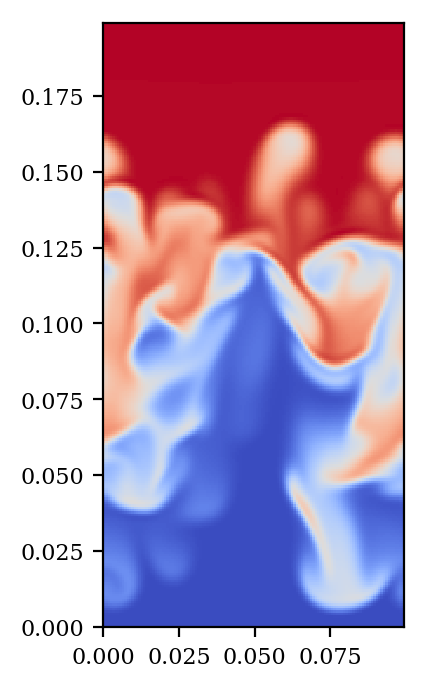

In [9]:
mylist = ['Fields/','Prho','/','038000']
filepath = delimiter.join(mylist)
databk = h5file.get(filepath)
rho = np.array(databk)
rho = np.transpose(rho[:,:,50])
rho = np.transpose(np.reshape(rho, (ny,nz)))

fig_pi = plt.figure(1, figsize = (4*1.214,4.0), dpi=200)
plt.rc('font', family='serif', size=8)
plt.imshow(rho, origin='none', extent=horizon_lim+vert_lim, aspect=1,
           cmap='coolwarm',vmin=rho_l,vmax=rho_h)


### read time

In [15]:
time_all = np.loadtxt('../time')
time = np.zeros(len(step))
index = 0
for x in step:
    time[index] = time_all[int(x)-1]
    index += 1

# Calculate Bubble Location in Multimode

In [16]:
bub_loc = np.zeros(len(step))

delimiter = ''
up_threhold = 0.95
index = 0
z = np.arange(0, nz)
ref = np.ones(nz)*up_threhold

for istep in step:

    mylist = ['Fields/', 'Prho', '/', istep]
    filepath = delimiter.join(mylist)
    databk = h5file.get(filepath)
    rho = np.array(databk)
    fh = np.zeros(nz)
    for i in range(nz):
        fh[i] = np.mean((rho[i,:,:] - 1)/9.0)
    idx = np.argwhere(np.diff(np.sign(fh - ref))).flatten()
    bub_loc[index] = z[idx][0]
    index += 1


Text(0,0.5,'$h/L$')

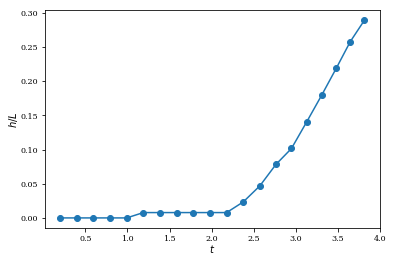

In [17]:
plt.plot(time,(bub_loc-bub_loc[0])*dz/Ly,'-o')
plt.xlabel('$t$', size=10, labelpad=-0.0 )
plt.ylabel('$h/L$', size=10, labelpad=-0.0, fontweight='bold')

# Calculate Mixing Width
https://www.nature.com/articles/nphys361.pdf

In [18]:
skip = 10
    
total_width = np.zeros(len(step))

ii = 0
for x in step:
    rho = h5file['/Fields/Prho/' + str(x).zfill(6)]
    rho = np.array(rho)
    rho = np.transpose(rho)
    #rho_l = np.average(rho[:,:,skip], axis=(0,1))
    #rho_h = np.average(rho[:,:,Nz-skip], axis=(0,1))
    rho = (rho - rho_l) / (rho_h - rho_l)
    rho_z = np.average(rho, axis=(0,1) )

    for i in range(np.size(rho_z)):
        if rho_z[i] <= 0.5:
            rho_z[i] = 2 * rho_z[i]
        else:
            rho_z[i] = 2 * (1 - rho_z[i])

    width = np.sum(rho_z) * dz
    print('At step ', x ,', width is ',width)
    total_width[ii] = width
    ii += 1

('At step ', '001000', ', width is ', 0.007114470599487499)
('At step ', '002000', ', width is ', 0.007265450970261259)
('At step ', '003000', ', width is ', 0.007404939911431064)
('At step ', '004000', ', width is ', 0.007565631060440951)
('At step ', '005000', ', width is ', 0.007701036427337194)
('At step ', '006000', ', width is ', 0.00786680541287608)
('At step ', '007000', ', width is ', 0.008030252972564987)
('At step ', '008000', ', width is ', 0.008253742979982959)
('At step ', '009000', ', width is ', 0.008573931512824168)
('At step ', '010000', ', width is ', 0.009181016879774588)
('At step ', '011000', ', width is ', 0.010294612172907572)
('At step ', '012000', ', width is ', 0.0122450375312401)
('At step ', '013000', ', width is ', 0.015272571896342483)
('At step ', '014000', ', width is ', 0.01920560810647692)
('At step ', '015000', ', width is ', 0.02377128506509958)
('At step ', '016000', ', width is ', 0.02856571898777334)
('At step ', '017000', ', width is ', 0.033348

### write to file

In [19]:
with open('mixing_width', 'wb') as f:
    np.savetxt(f,np.column_stack((step, time, total_width)), delimiter='\t', fmt='%s')

### plot alpha

('alpha mean is ', 0.0369914377548159)


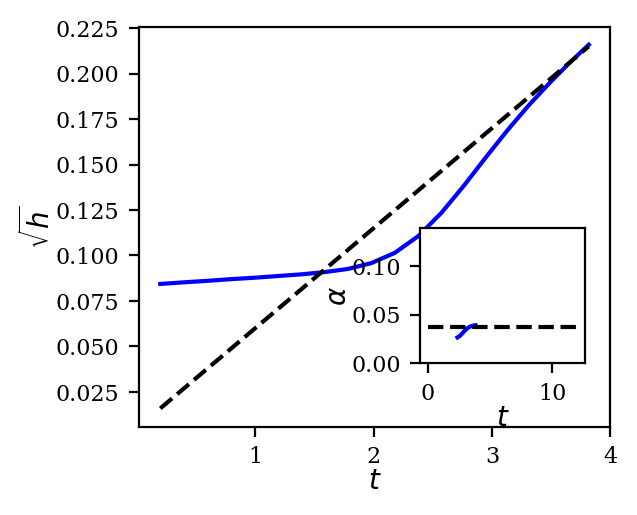

In [21]:
import sys
from itertools import cycle
alpha_start = 5


time_width = np.loadtxt('mixing_width')
time = time_width[:,1]
width = time_width[:,2]
alpha = np.divide(width, At*g* np.multiply(time,time))
alpha_mean = np.mean(alpha[alpha_start : alpha.size])
print('alpha mean is ',alpha_mean)
myfile = 'mixing_width_1024'

#fig_flux, ax1 = plt.figure(1, figsize=(2.6*1.214,2.6),dpi=200)
fig_flux, ax1 = plt.subplots(1, figsize=(2.6*1.214,2.6),dpi=200)
#fig_flux, ax1 = plt.subplots(1, figsize=(5.0*1.214,5.0),dpi=200)
plt.rc('font', family='serif', size=8)
ax1.plot(time, np.sqrt(width), 'b-', time, np.sqrt(At * g * alpha_mean) * time + 0.005, 'k--')
plt.xlabel('$t$', size=10, labelpad=-0.0 )
plt.ylabel('$\sqrt{h}$', size=10, labelpad=-0.0, fontweight='bold')

#pos_left, pos_bottom, pos_width, pos_height = [0.24, 0.6, 0.26, 0.26]
pos_left, pos_bottom, pos_width, pos_height = [0.65, 0.3, 0.26, 0.26]
ax2 = fig_flux.add_axes([pos_left, pos_bottom, pos_width, pos_height])
alpha_divide = np.divide(width, At * g * np.power(time, 2))
ax2.plot(time[11:time.size], alpha_divide[11:alpha_divide.size],'b-',
        #[time[11],time[time.size-1]],[alpha_mean,alpha_mean],'k--')
        [0,12],[alpha_mean,alpha_mean],'k--')
ax2.set_ylim([0, 0.14])
#ax2.set_xticks(np.arange(0,12.1,12))
#ax2.set_yticks(np.arange(0,0.14,0.12))
#ax2.set_xlabel('$t$', size=10,labelpad=-5, fontweight='bold')
#ax2.set_ylabel('$\\alpha$', size=10,labelpad=-5, fontweight='bold')
ax2.set_xlabel('$t$', size=10,labelpad=-0, fontweight='bold')
ax2.set_ylabel('$\\alpha$', size=10,labelpad=-0, fontweight='bold')
plt.tight_layout()
#for i in range(no_fluxes):
#    plt.semilogx(filter_width, fluxes[:,i], next(linecycler), label = flux_labels[i], markersize = 4)
#plt.xlabel('$\ell^{-1}$')
#plt.ylabel('KE fluxes')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.legend(flux_labels, loc='upper center', ncol = 3, fontsize = 8)
fig_flux.savefig(myfile + '.pdf', format = 'pdf')

plt.show()

# Calculate Bubble Velocity in Single-Mode

In [5]:
##initil function for bub velocity
if CFDmethod == True:
    CFD_x = Create_matrix_fd2(nx) / dx
    CFD_y = Create_matrix_fd2(ny) / dy
    CFD_z = Create_matrix_fd2(nz) / dz

bub_loc_all = np.zeros(len(step))
bub_loc_all_ori = np.zeros(len(step))
sp_loc_all = np.zeros(len(step))
bub_velo_all = np.zeros(len(step))
bub_velo_all_aver = np.zeros(len(step))
sp_velo_all = np.zeros(len(step))
bub_velo_all_ori = np.zeros(len(step))

seq = 0

for istep in step:
    
    print "doing", float(istep)/totalsteps*100, "%"
    

    mylist = ['Fields/', 'Prho', '/', istep]
    filepath = delimiter.join(mylist)
    databk = h5file.get(filepath)
    np_data = np.array(databk)
    if nx == 1:
        m1 = (np_data[:, ny/2-1, 0] + np_data[:, ny/2, 0] )/2
    else:
        m1 = (np_data[:, ny/2-1, nx/2-1] + np_data[:, ny/2, nx/2] 
      + np_data[:, ny/2-1, nx/2] + np_data[:, ny/2, nx/2-1])/4.0
    m2 = np_data[:, 0, 0]
    m1_filter=m1.copy();    
    m2_filter=m2.copy();    
    for jstep in range(2,nz-3):
        m1_filter[jstep]=(m1[jstep-2]+m1[jstep-1]+m1[jstep]+m1[jstep+1]+m1[jstep+2])/5;
        m2_filter[jstep]=(m2[jstep-2]+m2[jstep-1]+m2[jstep]+m2[jstep+1]+m2[jstep+2])/5;


    m1_grad = high_order_gradient(m1_filter,dx,6)
    m2_grad = high_order_gradient(m2_filter,dx,6)


    sp_loc = np.argmax(m1_grad)
    bub_loc = np.argmax(m2_grad)

    sp_loc_all[seq] = sp_loc
    bub_loc_all[seq] = bub_loc

    mylist = ['Fields/', 'PVz', '/', istep]
    filepath = delimiter.join(mylist)
    databk = h5file.get(filepath)
    np_data = np.array(databk)

    #consider 2D/3D case
    if nx == 1:
        m1 = (np_data[:, ny/2-1, 0] + np_data[:, ny/2, 0] )/2
    else:
        m1 = (np_data[:, ny/2-1, nx/2-1] + np_data[:, ny/2, nx/2] 
      + np_data[:, ny/2-1, nx/2] + np_data[:, ny/2, nx/2-1])/4.0
    m2 = np_data[:, 0, 0]
    sp_velo = m1[sp_loc]
    bub_velo = m2[bub_loc]
    bub_velo_all[seq] = bub_velo
    sp_velo_all[seq] = sp_velo

    seq += 1


doing 1.0 %
doing 2.0 %
doing 3.0 %
doing 4.0 %
doing 5.0 %
doing 6.0 %
doing 7.0 %
doing 8.0 %
doing 9.0 %
doing 10.0 %
doing 11.0 %
doing 12.0 %
doing 13.0 %
doing 14.0 %
doing 15.0 %
doing 16.0 %
doing 17.0 %
doing 18.0 %
doing 19.0 %
doing 20.0 %
doing 21.0 %
doing 22.0 %
doing 23.0 %
doing 24.0 %
doing 25.0 %
doing 26.0 %
doing 27.0 %
doing 28.0 %
doing 29.0 %
doing 30.0 %
doing 31.0 %
doing 32.0 %
doing 33.0 %
doing 34.0 %
doing 35.0 %
doing 36.0 %
doing 37.0 %
doing 38.0 %
doing 39.0 %
doing 40.0 %
doing 41.0 %
doing 42.0 %
doing 43.0 %
doing 44.0 %
doing 45.0 %
doing 46.0 %
doing 47.0 %
doing 48.0 %
doing 49.0 %
doing 50.0 %
doing 51.0 %
doing 52.0 %
doing 53.0 %
doing 54.0 %
doing 55.0 %
doing 56.0 %
doing 57.0 %
doing 58.0 %
doing 59.0 %
doing 60.0 %
doing 61.0 %
doing 62.0 %
doing 63.0 %
doing 64.0 %
doing 65.0 %
doing 66.0 %
doing 67.0 %
doing 68.0 %
doing 69.0 %
doing 70.0 %
doing 71.0 %
doing 72.0 %
doing 73.0 %
doing 74.0 %
doing 75.0 %
doing 76.0 %
doing 77.0 %
doing 78

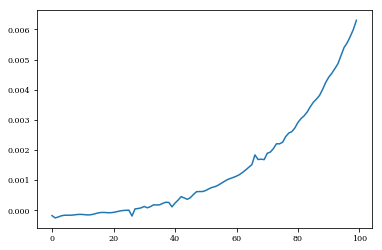

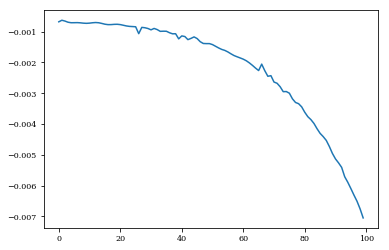

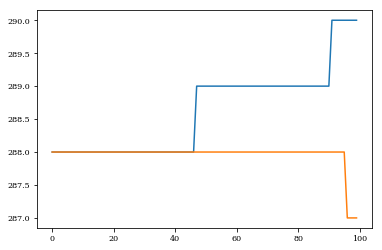

<Figure size 432x288 with 0 Axes>

In [6]:
plt.plot(bub_velo_all)
plt.show()
plt.savefig('bubvel.eps', format='eps', dpi=300)
plt.clf()

plt.plot(sp_velo_all)
plt.show()
plt.savefig('spkvel.eps', format='eps', dpi=300)
plt.clf()

plt.plot(bub_loc_all)
plt.plot(sp_loc_all)
plt.savefig('loc.eps', format='eps', dpi=300)
plt.show()
plt.clf()

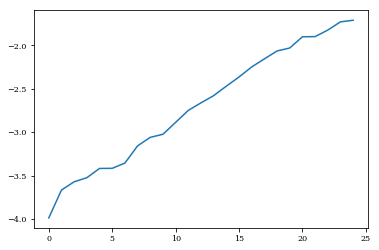

<Figure size 432x288 with 0 Axes>

In [7]:
plt.plot(np.log(bub_velo_all))
plt.show()
plt.clf()

# Compared to LSA

In [12]:
a = 0.33333
g = 1
k = 2*np.pi/waveLen
time = 5.02
Bcode = 0.2
B = Bcode*np.sqrt(4*np.pi)

In [13]:
n = np.sqrt(a*g*k - B*B*k*k/(rho_h+rho_l)/(2*np.pi))
lsa = np.multiply(n,np.linspace(0,time,len(step)))

/gpfs/fs1/sfw2/anaconda/5.3.0b/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


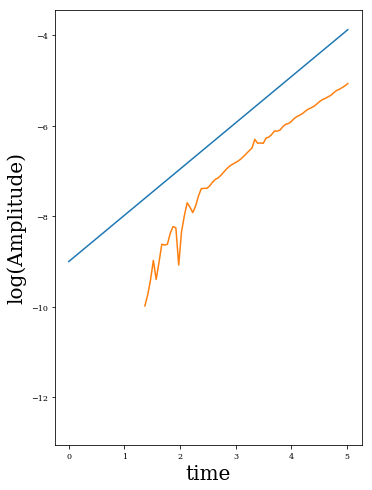

<Figure size 432x288 with 0 Axes>

In [14]:
plt.figure(figsize=(5.5,8))
plt.plot(np.linspace(0,time,len(step)),lsa-9)
#plt.xlim(0,5)
#plt.ylim(-10,0)
plt.xlabel('time', fontsize=20)
plt.ylabel('log(Amplitude)',fontsize=20)
plt.plot(np.linspace(0,time,len(step)),np.log(bub_velo_all))
plt.figsize=(2,1)
plt.show()
plt.clf()

## Visulazation
### vorticity

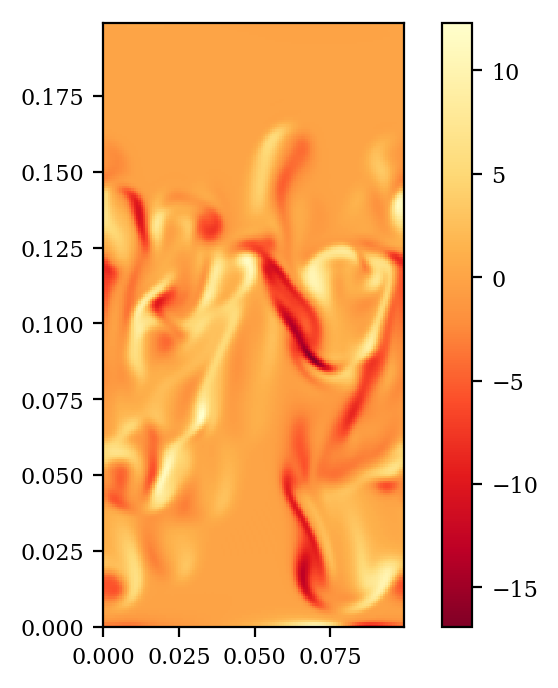

In [7]:
#calculate bubble and spike location
step = ['038000']
for istep in step:
    #obtain velocity 
    
    mylist = ['Fields/',variable[0],'/',istep]
    filepath = delimiter.join(mylist)
    databk = h5file.get(filepath)
    vx = np.array(databk)
    mylist = ['Fields/',variable[1],'/',istep]
    filepath = delimiter.join(mylist)
    databk = h5file.get(filepath)
    vy = np.array(databk)
    mylist = ['Fields/',variable[2],'/',istep]
    filepath = delimiter.join(mylist)
    databk = h5file.get(filepath)
    vz = np.array(databk)
     
    #calculate vorticity
    if nx == 1:
        vorx = np.gradient(vz, dz, axis=1) - np.gradient(vy, dz, axis=0)
    else:
        vorx = np.gradient(vz, dz, axis=1) - np.gradient(vy, dz, axis=0)
        vory = np.gradient(vx, dz, axis=0) - np.gradient(vz, dz, axis=2)
        vorz = np.gradient(vy, dz, axis=2) - np.gradient(vx, dz, axis=1)
    if nx == 1:
    
        vorx = np.transpose(vorx)
        vorx = np.transpose(np.reshape(vorx, (ny,nz)))
    else:
     
        vorx = np.transpose(vorx[:,:,50])
        vorx = np.transpose(np.reshape(vorx, (ny,nz)))
    fig_pi = plt.figure(1, figsize = (4*1.214,4.0), dpi=200)
    plt.rc('font', family='serif', size=8)
    plt.imshow(vorx, origin='none', extent=horizon_lim+vert_lim, aspect=1,
           cmap='YlOrRd_r')
    plt.colorbar()

### B field in Tesla

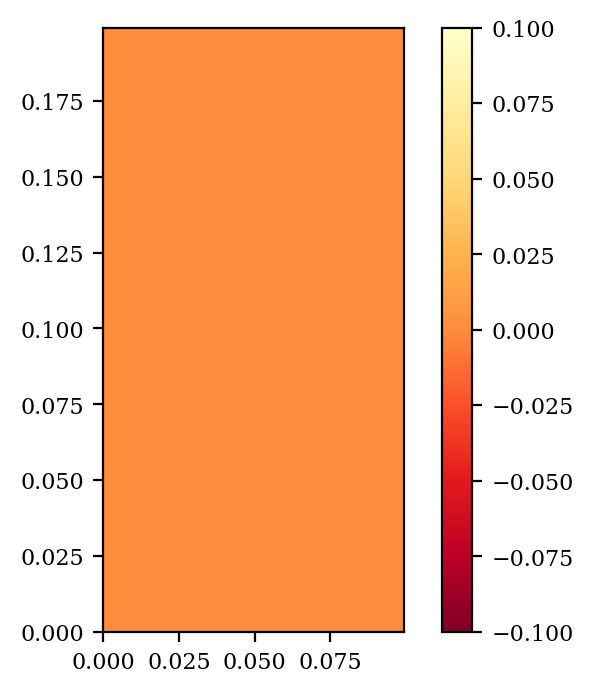

In [6]:
constant = np.sqrt(1.2566*10**(-6))
for istep in step:
    #obtain velocity     
    mylist = ['Fields/','PBx','/',istep]
    filepath = delimiter.join(mylist)
    databk = h5file.get(filepath)
    vorx = np.array(databk)/constant
    if nx == 1:
    
        vorx = np.transpose(vorx)
        vorx = np.transpose(np.reshape(vorx, (ny,nz)))
    else:
     
        vorx = np.transpose(vorx[:,:,50])
        vorx = np.transpose(np.reshape(vorx, (ny,nz)))
    fig_pi = plt.figure(1, figsize = (4*1.214,4.0), dpi=200)
    plt.rc('font', family='serif', size=8)
    plt.imshow(vorx, origin='none', extent=horizon_lim+vert_lim, aspect=1,
           cmap='YlOrRd_r')
    plt.colorbar()